In [339]:
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')

In [340]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from datetime import datetime
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.var_model import VAR
from matplotlib import pyplot
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox

In [341]:
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

def difference(old_values, d):
    new_values = list()
    for i in range(d, len(old_values)):
        value = old_values[i] - old_values[i - d]
        new_values.append(value)
    return new_values

In [342]:
zillow = pd.read_csv('zillow-carlifornia.csv', parse_dates=True,squeeze=True)
zillow.head()

,Date,MedianSoldPrice_AllHomes.California,MedianMortageRate,UnemploymentRate,MedianRentalPrice_AllHomes.California
0,2004-01-31,326752.55,5.02,7.9,NaN
1,2004-02-29,329501.50,4.94,7.8,NaN
2,2004-03-31,340125.45,4.74,7.8,NaN
3,2004-04-30,355329.50,5.16,7.5,NaN
4,2004-05-31,367818.15,5.64,7.3,NaN


In [343]:
zillow.rename(columns={"MedianSoldPrice_AllHomes.California": "MedianSoldPrice"}, inplace=True)
zillow.Date = pd.to_datetime(zillow.Date)

In [344]:
data  = zillow.loc[zillow['Date']<'2016-01-01']
test = zillow.loc[zillow['Date']>'2016-01-01']

## Initial Look at Data

In [345]:
median_sold = data['MedianSoldPrice']

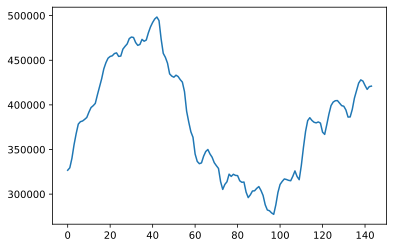

In [346]:
plt.plot(median_sold)

## Difference Data

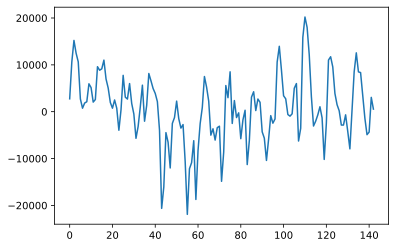

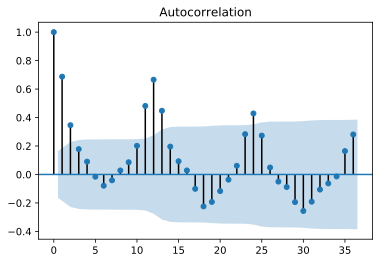

Results of Dickey-Fuller Test:
Test Statistic                  -1.687305
p-value                          0.437665
#Lags Used                      12.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [347]:
# d = 1
d1 = difference(median_sold, d=1)
plt.plot(d1) 
plot_acf(d1,lags=36) 
plt.show()
adf_test(d1)

#### Need to do another differencing:

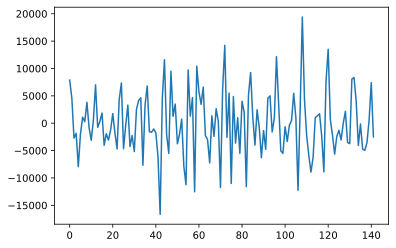

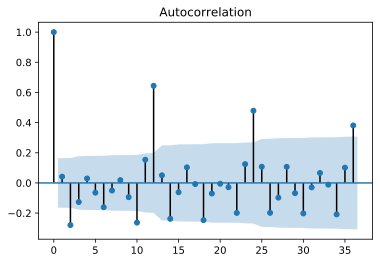

Results of Dickey-Fuller Test:
Test Statistic                  -4.918846
p-value                          0.000032
#Lags Used                      11.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [348]:
d2 = difference(d1, d=1)
plt.plot(d2) 
plot_acf(d2,lags=36) 
plt.show()
adf_test(d2)

#### Removed trend. Need to remove seasonality. ACF tells us lag = 12.

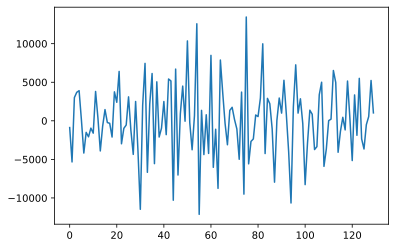

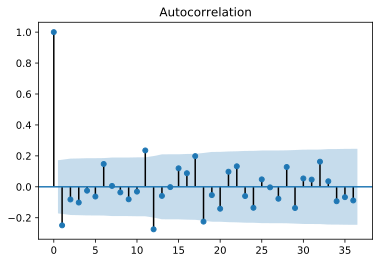

Results of Dickey-Fuller Test:
Test Statistic                  -5.149454
p-value                          0.000011
#Lags Used                      13.000000
Number of Observations Used    116.000000
Critical Value (1%)             -3.488022
Critical Value (5%)             -2.886797
Critical Value (10%)            -2.580241
dtype: float64


In [349]:
d3 = difference(d2, d=12)

plt.plot(d3)
plot_acf(d3,lags=36) 
plt.show()
adf_test(d3)

#### Seasonality is now removed. After one time differencing.

# Univariate Models - Median Sold Price


## Split Data

In [350]:
# Train/Test Split for Median Sold
train_size = int(len(median_sold) * 0.75)
train, test = median_sold[:train_size], median_sold[train_size:]

### SARIMA Model

In [351]:
# Fitting univariate Sarima model
uni_sarima_model = pm.auto_arima(train, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=2, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(uni_sarima_model.summary())

Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 1, 1, 12); AIC=1871.765, BIC=1884.482, Fit time=0.620 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 1, 0, 12); AIC=1867.270, BIC=1872.356, Fit time=0.013 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(1, 1, 0, 12); AIC=1871.057, BIC=1881.231, Fit time=0.153 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 1, 1, 12); AIC=1871.296, BIC=1881.469, Fit time=0.238 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(1, 1, 0, 12); AIC=1869.071, BIC=1876.701, Fit time=0.091 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 1, 1, 12); AIC=1869.070, BIC=1876.700, Fit time=0.156 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(1, 1, 1, 12); AIC=1871.118, BIC=1881.291, Fit time=0.124 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(0, 1, 0, 12); AIC=1869.284, BIC=1876.914, Fit time=0.075 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 1, 0, 12); AIC=1869.529, BIC=1877.159, Fit time=0.043 seconds
Fit ARIMA: order=(1, 2, 1) s

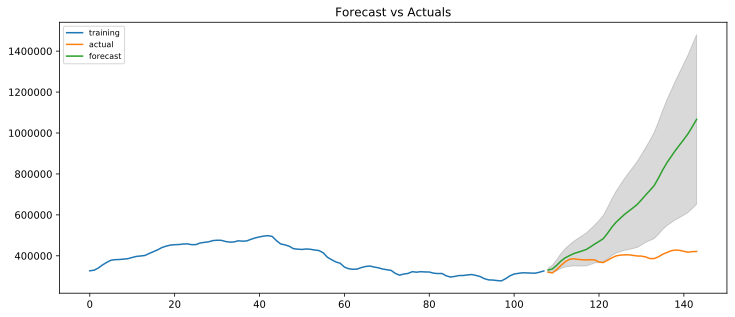

In [352]:
# Prediction plot
fitted = uni_sarima_model.fit(train)
fc, conf = fitted.predict(len(test),return_conf_int=True,alpha=0.05)
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [353]:
# Calculating the rmse

mse = ((fc_series - test) ** 2).mean()
rmse=round(np.sqrt(mse), 2)
print(rmse)

307111.42


### TES (Exponential Smoothing) Model

In [354]:
# TES model
uni_tes_model1 = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12,damped=True)
uni_tes_model2 = ExponentialSmoothing(train, trend="add", seasonal="mul", seasonal_periods=12, damped=True)
uni_tes_model3 = ExponentialSmoothing(train, trend="mul", seasonal="mul", seasonal_periods=12, damped=True)
uni_tes_model4 = ExponentialSmoothing(train, trend="mul", seasonal="add", seasonal_periods=12, damped=True)

fit = uni_tes_model1.fit()
pred = fit.forecast(len(test))
fit2 = uni_tes_model2.fit()
pred2 = fit2.forecast(len(test))
fit3 = uni_tes_model3.fit()
pred3 = fit3.forecast(len(test))
fit4 = uni_tes_model4.fit()
pred4 = fit4.forecast(len(test))

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:863: RuntimeWarning: invalid value encountered in power
  (alphac * trended(lvls[i - 1], dampen(b[i - 1], phi)))
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:866: RuntimeWarning: invalid value encountered in power
  (betac * dampen(b[i - 1], phi))
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:867: RuntimeWarning: invalid value encountered in power
  s[i + m - 1] = y_gamma

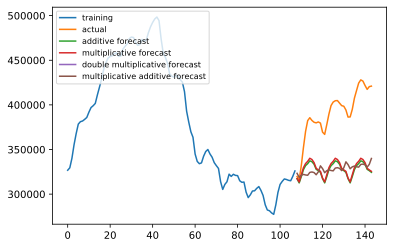

In [355]:
# Prediction Plot
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred, label='additive forecast')
plt.plot(pred2, label='multiplicative forecast')
plt.plot(pred3, label='double multiplicative forecast')
plt.plot(pred4, label='multiplicative additive forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [356]:
# Calculating RMSE
rmse1 = np.sqrt(np.mean(np.square(test.values - pred.values)))
rmse2 = np.sqrt(np.mean(np.square(test.values - pred2.values)))
rmse3 = np.sqrt(np.mean(np.square(test.values - pred3.values)))
rmse4 = np.sqrt(np.mean(np.square(test.values - pred4.values)))


print(rmse1)
print(rmse2)
print(rmse3)
print(rmse4)

66504.55798091268
64851.9495575102
nan
66092.52691596653


# Multivariate Models - SARIMAX

### Median Sold Price ~ Median Mortgage Rate

In [357]:
#SARIMAX
MedianMortageRate=data.MedianMortageRate
exog_train=MedianMortageRate[:train_size, None]
exog_test=MedianMortageRate[train_size:,None]


In [358]:
# Fitting SARIMAX model
sarimax_model1 = SARIMAX(train, order=(1,2,1),exog=exog_train)
fitx=sarimax_model1.fit()
print(fitx.summary())

                           Statespace Model Results                           
Dep. Variable:        MedianSoldPrice   No. Observations:                  108
Model:               SARIMAX(1, 2, 1)   Log Likelihood               -1059.578
Date:                Tue, 10 Dec 2019   AIC                           2127.157
Time:                        22:41:20   BIC                           2137.810
Sample:                             0   HQIC                          2131.475
                                - 108                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          4227.7464   2464.723      1.715      0.086    -603.023    9058.516
ar.L1          0.8204      0.092      8.938      0.000       0.641       1.000
ma.L1         -0.9279      0.076    -12.273      0.0

In [359]:
fc = fitx.predict(start=108, end=143, exog=exog_test)

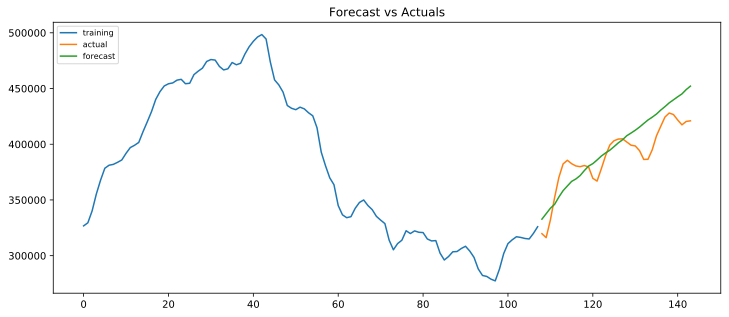

In [360]:
# Prediction plot 
fc_series = pd.Series(fc)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [361]:
# RMSE calculation
mse = ((fc_series - test) ** 2).mean()
rmse=np.sqrt(mse)
print(rmse)


17690.740293273982


### Median Sold Price ~ Unemployment Rate


In [362]:
# Train-test split
UnemploymentRate=data.UnemploymentRate
exog_train=UnemploymentRate[:train_size, None]
exog_test=UnemploymentRate[train_size:,None]

In [363]:
# Fitting SARIMAX model
sarimax_model2 = SARIMAX(train, order=(1,2,1),exog=exog_train)
fitx=sarimax_model2.fit()
print(fitx.summary())

                           Statespace Model Results                           
Dep. Variable:        MedianSoldPrice   No. Observations:                  108
Model:               SARIMAX(1, 2, 1)   Log Likelihood               -1061.204
Date:                Tue, 10 Dec 2019   AIC                           2130.409
Time:                        22:41:22   BIC                           2141.063
Sample:                             0   HQIC                          2134.727
                                - 108                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          -434.2420    637.973     -0.681      0.496   -1684.646     816.162
ar.L1          0.8277      0.092      8.951      0.000       0.646       1.009
ma.L1         -0.9284      0.078    -11.949      0.0

In [364]:
fc = fitx.predict(start=108, end=143, exog=exog_test)

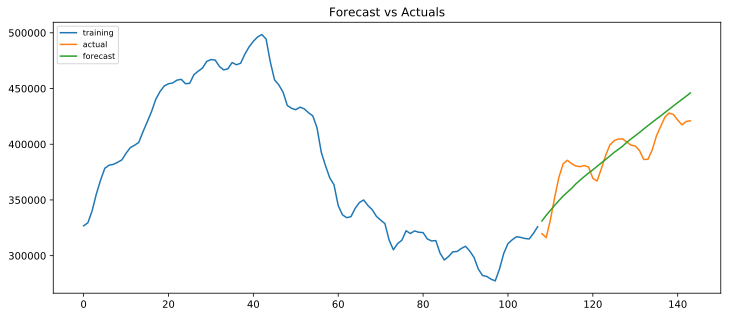

In [365]:
# Prediction Plot
fc_series = pd.Series(fc)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [366]:
# Calculating RMSE
mse = ((fc_series - test) ** 2).mean()
rmse=np.sqrt(mse)
print(rmse)


16105.738850097192


### Median Sold Price ~ Median Mortgage Rate + Unemployment Rate

In [367]:
# Train/Test Split for Exogeneous Variables: Median Mortgage, Unemployment Rate
X = data[['MedianMortageRate','UnemploymentRate']]
exog_train, exog_test = X[:train_size], X[train_size:]

In [368]:
# Fitting SARIMAX model
sarimax_model3 = pm.auto_arima(train, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=2, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(sarimax_model3.summary())

Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 1, 1, 12); AIC=1871.765, BIC=1884.482, Fit time=0.589 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 1, 0, 12); AIC=1867.270, BIC=1872.356, Fit time=0.012 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(1, 1, 0, 12); AIC=1871.057, BIC=1881.231, Fit time=0.133 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 1, 1, 12); AIC=1871.296, BIC=1881.469, Fit time=0.290 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(1, 1, 0, 12); AIC=1869.071, BIC=1876.701, Fit time=0.088 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 1, 1, 12); AIC=1869.070, BIC=1876.700, Fit time=0.142 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(1, 1, 1, 12); AIC=1871.118, BIC=1881.291, Fit time=0.137 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(0, 1, 0, 12); AIC=1869.284, BIC=1876.914, Fit time=0.079 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 1, 0, 12); AIC=1869.529, BIC=1877.159, Fit time=0.051 seconds
Fit ARIMA: order=(1, 2, 1) s

In [369]:
# Assumes one way direction Unemployment predict -> only Bankcrupcy
modelx = SARIMAX(train, order=(1,2,1),exog=exog_train)
fitx=modelx.fit()
print(fitx.summary())

                           Statespace Model Results                           
Dep. Variable:        MedianSoldPrice   No. Observations:                  108
Model:               SARIMAX(1, 2, 1)   Log Likelihood               -1059.459
Date:                Tue, 10 Dec 2019   AIC                           2128.919
Time:                        22:41:32   BIC                           2142.236
Sample:                             0   HQIC                          2134.316
                                - 108                                         
Covariance Type:                  opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
MedianMortageRate  4122.7149   2507.259      1.644      0.100    -791.422    9036.851
UnemploymentRate   -339.5362    628.343     -0.540      0.589   -1571.065     891.993
ar.L1                 0.

In [370]:
fc = fitx.predict(start=108, end=143, exog=exog_test)

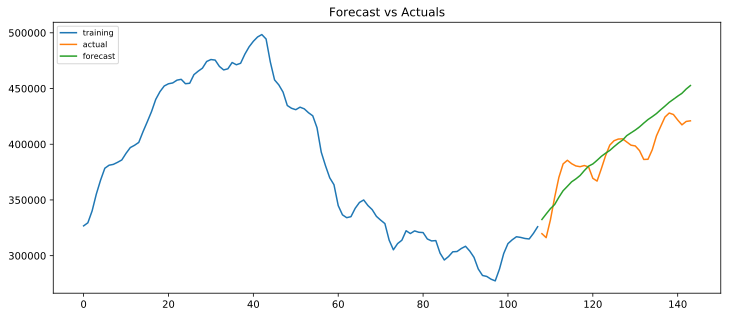

In [371]:
# Prediction plot
fc_series = pd.Series(fc)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [372]:
# Calculating RMSE
mse = ((fc_series - test) ** 2).mean()
rmse=np.sqrt(mse)
print(rmse)

17892.50856225637


# Multivariate Models - VAR

### Median Sold Price ~ Median Mortgage Rate

In [373]:
# Dropping the column 'UnemploymentRate' to create a new dataframe.
# Dividing into train and test set.

df_var = data.drop(columns = ['MedianRentalPrice_AllHomes.California', 'Date'])

# Renaming the columns of the dataframe.
df_var.columns = ['MedianSoldPrice', 'MedianMortageRate', 'UnemploymentRate']

df_var_price_mortgage = df_var.drop(columns = ['UnemploymentRate'])[:144]
train = df_var_price_mortgage[:int(0.75*(len(df_var_price_mortgage)))]
test = df_var_price_mortgage[int(0.75*(len(df_var_price_mortgage))):]
train.head()

,MedianSoldPrice,MedianMortageRate
0,326752.55,5.02
1,329501.50,4.94
2,340125.45,4.74
3,355329.50,5.16
4,367818.15,5.64


In [374]:
# Fitting an AR(1) process
    
var_model1 = VAR(endog=train)
var_model1_fit = var_model1.fit(1)
print(var_model1_fit.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 10, Dec, 2019
Time:                     22:41:34
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    14.3703
Nobs:                     107.000    HQIC:                   14.2812
Log likelihood:          -1058.45    FPE:                1.49923e+06
AIC:                      14.2204    Det(Omega_mle):     1.41857e+06
--------------------------------------------------------------------
Results for equation MedianSoldPrice
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                     3459.301759      4050.322252            0.854           0.393
L1.MedianSoldPrice           1.023720         0.024570           41.666           0.000
L1.MedianMortageRate  

In [375]:
# Predicting the MedianSoldPrice of the test sample.

fc = var_model1_fit.forecast(var_model1_fit.y, steps=len(test))
cols = df_var_price_mortgage.columns
pred = pd.DataFrame(index=test.index,columns=[cols])


for j in range(0,2):
    for i in range(0, len(fc)):
        pred.iloc[i][j] = fc[i][j]


/usr/local/lib/python3.7/site-packages/statsmodels/base/wrapper.py:35: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


In [376]:
# Calculating the rmse on the validation data for AR(1)

diff = (pred['MedianSoldPrice'].squeeze().iloc[:21] - test['MedianSoldPrice'].squeeze().iloc[:21])
mse = (diff ** 2).mean()
rmse = round(np.sqrt(mse), 2)
print(rmse)


32122.98


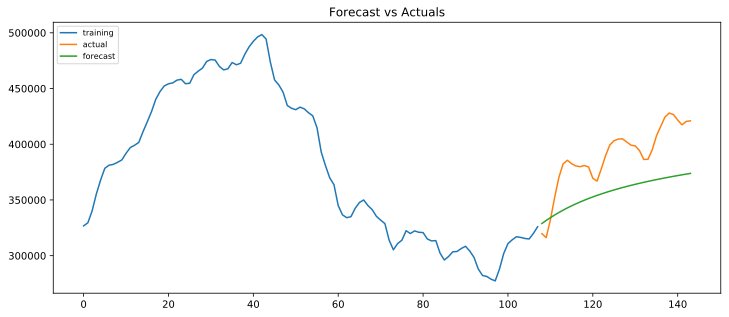

In [377]:
# Plotting the actual vs. forecast

plt.figure(figsize=(12,5), dpi=100)
plt.plot(train.MedianSoldPrice, label='training')
plt.plot(test.MedianSoldPrice, label='actual')
plt.plot(pred.MedianSoldPrice, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [378]:
# Fitting an AR(2) process
    
var_model2 = VAR(endog=train)
var_model2_fit = var_model2.fit(2)
print(var_model2_fit.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 10, Dec, 2019
Time:                     22:41:37
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    13.8614
Nobs:                     106.000    HQIC:                   13.7120
Log likelihood:          -1012.15    FPE:                    814493.
AIC:                      13.6102    Det(Omega_mle):         742768.
--------------------------------------------------------------------
Results for equation MedianSoldPrice
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                     4421.520569      3000.020890            1.474           0.141
L1.MedianSoldPrice           1.660193         0.075275           22.055           0.000
L1.MedianMortageRate  

In [379]:
# Predicting the MedianSoldPrice of the test sample.

fc = var_model2_fit.forecast(var_model2_fit.y, steps=len(test))
cols = df_var_price_mortgage.columns
pred = pd.DataFrame(index=test.index,columns=[cols])

for j in range(0,2):
    for i in range(0, len(fc)):
        pred.iloc[i][j] = fc[i][j]


/usr/local/lib/python3.7/site-packages/statsmodels/base/wrapper.py:35: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


In [380]:
# Calculating the rmse on the validation data for AR(2)

diff = (pred['MedianSoldPrice'].squeeze().iloc[:21] - test['MedianSoldPrice'].squeeze().iloc[:21])
mse = (diff ** 2).mean()
rmse = round(np.sqrt(mse), 2)
print(rmse)


14090.08


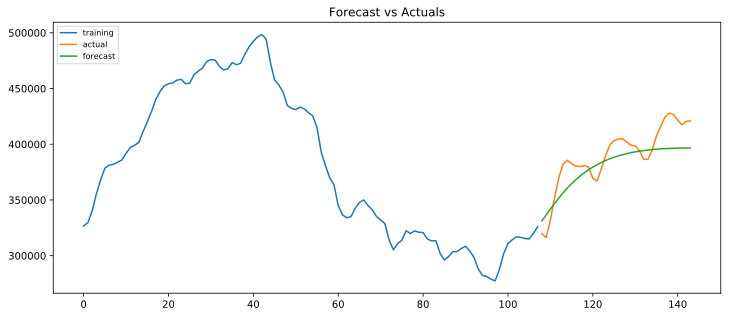

In [381]:
# Plotting the actual vs. forecast

plt.figure(figsize=(12,5), dpi=100)
plt.plot(train.MedianSoldPrice, label='training')
plt.plot(test.MedianSoldPrice, label='actual')
plt.plot(pred.MedianSoldPrice, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [382]:
# Fitting an AR(3) process
    
var_model3 = VAR(endog=train)
var_model3_fit = var_model3.fit(3)
print(var_model3_fit.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 10, Dec, 2019
Time:                     22:41:40
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    13.9842
Nobs:                     105.000    HQIC:                   13.7737
Log likelihood:          -999.571    FPE:                    831305.
AIC:                      13.6304    Det(Omega_mle):         730639.
--------------------------------------------------------------------
Results for equation MedianSoldPrice
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                     3233.609250      3034.525954            1.066           0.287
L1.MedianSoldPrice           1.738195         0.102431           16.969           0.000
L1.MedianMortageRate  

In [383]:
# Predicting the MedianSoldPrice of the test sample.

fc = var_model3_fit.forecast(var_model3_fit.y, steps=len(test))
cols = df_var_price_mortgage.columns
pred = pd.DataFrame(index=test.index,columns=[cols])

for j in range(0,2):
    for i in range(0, len(fc)):
        pred.iloc[i][j] = fc[i][j]


/usr/local/lib/python3.7/site-packages/statsmodels/base/wrapper.py:35: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


In [384]:
# Calculating the rmse on the validation data for AR(3)

diff = (pred['MedianSoldPrice'].squeeze().iloc[:21] - test['MedianSoldPrice'].squeeze().iloc[:21])
mse = (diff ** 2).mean()
rmse = round(np.sqrt(mse), 2)
print(rmse)


21090.75


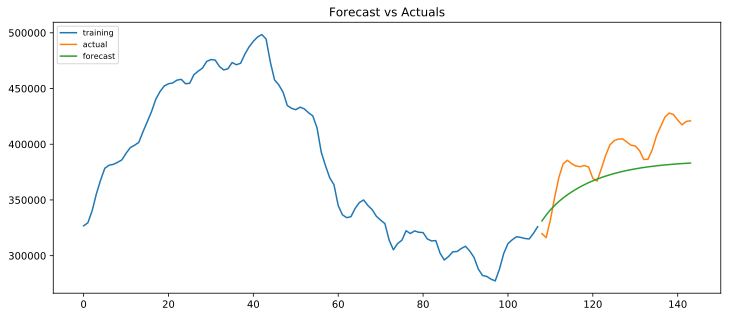

In [385]:
# Plotting the actual vs. forecast

plt.figure(figsize=(12,5), dpi=100)
plt.plot(train.MedianSoldPrice, label='training')
plt.plot(test.MedianSoldPrice, label='actual')
plt.plot(pred.MedianSoldPrice, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### Median Sold Price ~ Unemployment Rate

In [386]:
# Dropping the column 'MedianMortageRate' to create a new dataframe.
# Dividing into train and test set.

df_var_price_unemployment = df_var.drop(columns = ['MedianMortageRate'])[:144]
train = df_var_price_unemployment[:int(0.75*(len(df_var_price_unemployment)))]
test = df_var_price_unemployment[int(0.75*(len(df_var_price_unemployment))):]
train.head()

,MedianSoldPrice,UnemploymentRate
0,326752.55,7.9
1,329501.50,7.8
2,340125.45,7.8
3,355329.50,7.5
4,367818.15,7.3


In [387]:
# Fitting an AR(1) process
    
var_model1 = VAR(endog=train)
var_model1_fit = var_model1.fit(1)
print(var_model1_fit.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 10, Dec, 2019
Time:                     22:41:45
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    16.5243
Nobs:                     107.000    HQIC:                   16.4352
Log likelihood:          -1173.68    FPE:                1.29217e+07
AIC:                      16.3744    Det(Omega_mle):     1.22265e+07
--------------------------------------------------------------------
Results for equation MedianSoldPrice
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                  -27127.862476     11457.297487           -2.368           0.018
L1.MedianSoldPrice          1.020443         0.013691           74.535           0.000
L1.UnemploymentRate      2

In [388]:
# Predicting the MedianSoldPrice of the test sample.

fc = var_model1_fit.forecast(var_model1_fit.y, steps=len(test))
cols = df_var_price_unemployment.columns
pred = pd.DataFrame(index=test.index,columns=[cols])

for j in range(0,2):
    for i in range(0, len(fc)):
        pred.iloc[i][j] = fc[i][j]


/usr/local/lib/python3.7/site-packages/statsmodels/base/wrapper.py:35: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


In [389]:
# Calculating the rmse on the validation data for AR(1)

diff = (pred['MedianSoldPrice'].squeeze().iloc[:21] - test['MedianSoldPrice'].squeeze().iloc[:21])
mse = (diff ** 2).mean()
rmse = round(np.sqrt(mse), 2)
print(rmse)


58081.31


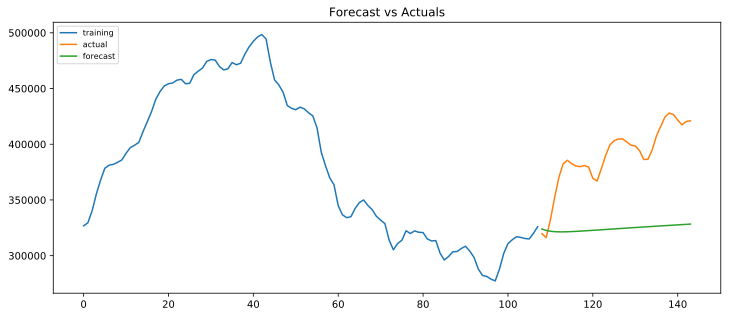

In [390]:
# Plotting the actual vs. forecast

plt.figure(figsize=(12,5), dpi=100)
plt.plot(train.MedianSoldPrice, label='training')
plt.plot(test.MedianSoldPrice, label='actual')
plt.plot(pred.MedianSoldPrice, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [391]:
# Fitting an AR(2) process
    
var_model2 = VAR(endog=train)
var_model2_fit = var_model2.fit(2)
print(var_model2_fit.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 10, Dec, 2019
Time:                     22:41:47
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    16.0981
Nobs:                     106.000    HQIC:                   15.9487
Log likelihood:          -1130.70    FPE:                7.62534e+06
AIC:                      15.8468    Det(Omega_mle):     6.95385e+06
--------------------------------------------------------------------
Results for equation MedianSoldPrice
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                   -8883.451535      9784.324093           -0.908           0.364
L1.MedianSoldPrice          1.665293         0.073611           22.623           0.000
L1.UnemploymentRate       

In [392]:
# Predicting the MedianSoldPrice of the test sample.

fc = var_model2_fit.forecast(var_model2_fit.y, steps=len(test))
cols = df_var_price_unemployment.columns
pred = pd.DataFrame(index=test.index,columns=[cols])

for j in range(0,2):
    for i in range(0, len(fc)):
        pred.iloc[i][j] = fc[i][j]

/usr/local/lib/python3.7/site-packages/statsmodels/base/wrapper.py:35: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


In [393]:
# Calculating the rmse on the validation data for AR(2)

diff = (pred['MedianSoldPrice'].squeeze().iloc[:21] - test['MedianSoldPrice'].squeeze().iloc[:21])
mse = (diff ** 2).mean()
rmse = round(np.sqrt(mse), 2)
print(rmse)


39161.22


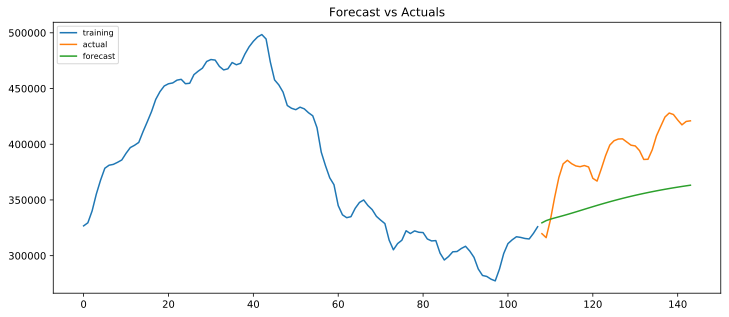

In [394]:
# Plotting the actual vs. forecast

plt.figure(figsize=(12,5), dpi=100)
plt.plot(train.MedianSoldPrice, label='training')
plt.plot(test.MedianSoldPrice, label='actual')
plt.plot(pred.MedianSoldPrice, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [395]:
# Fitting an AR(3) process
    
var_model3 = VAR(endog=train)
var_model3_fit = var_model3.fit(3)
print(var_model3_fit.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 10, Dec, 2019
Time:                     22:41:50
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    16.2086
Nobs:                     105.000    HQIC:                   15.9982
Log likelihood:          -1116.35    FPE:                7.68797e+06
AIC:                      15.8548    Det(Omega_mle):     6.75701e+06
--------------------------------------------------------------------
Results for equation MedianSoldPrice
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                  -13429.556473     10847.537593           -1.238           0.216
L1.MedianSoldPrice          1.741758         0.099216           17.555           0.000
L1.UnemploymentRate       

In [396]:
# Predicting the MedianSoldPrice of the test sample.

fc = var_model3_fit.forecast(var_model3_fit.y, steps=len(test))
cols = df_var_price_unemployment.columns
pred = pd.DataFrame(index=test.index,columns=[cols])

for j in range(0,2):
    for i in range(0, len(fc)):
        pred.iloc[i][j] = fc[i][j]

/usr/local/lib/python3.7/site-packages/statsmodels/base/wrapper.py:35: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


In [397]:
# Calculating the rmse on the validation data for AR(3)

diff = (pred['MedianSoldPrice'].squeeze().iloc[:21] - test['MedianSoldPrice'].squeeze().iloc[:21])
mse = (diff ** 2).mean()
rmse = round(np.sqrt(mse), 2)
print(rmse)


55458.93


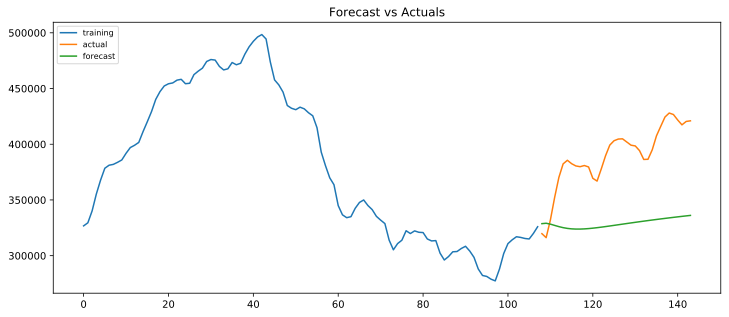

In [398]:
# Plotting the actual vs. forecast

plt.figure(figsize=(12,5), dpi=100)
plt.plot(train.MedianSoldPrice, label='training')
plt.plot(test.MedianSoldPrice, label='actual')
plt.plot(pred.MedianSoldPrice, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### Median Sold Price ~ Median Mortgage Rate + Unemployment Rate

In [399]:
# Train/Test Split for Exogeneous Variables: Median Mortgage, Unemployment Rate
X = data[['MedianSoldPrice','MedianMortageRate','UnemploymentRate']]
exog_train, exog_test = X[:train_size], X[train_size:]

In [400]:
# Fitting an AR(1) process
var_model1 = VAR(endog=exog_train)
var_model1_fit = var_model1.fit(1)
print(var_model1_fit.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 10, Dec, 2019
Time:                     22:42:04
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    13.1529
Nobs:                     107.000    HQIC:                   12.9746
Log likelihood:          -1131.12    FPE:                    382013.
AIC:                      12.8531    Det(Omega_mle):         342185.
--------------------------------------------------------------------
Results for equation MedianSoldPrice
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                   -26234.737319     11412.464591           -2.299           0.022
L1.MedianSoldPrice           1.052738         0.026017           40.463           0.000
L1.MedianMortageRate  

In [401]:
# Predicting the MedianSoldPrice of the test sample.
fc = var_model1_fit.forecast(var_model1_fit.y, steps=len(exog_test))
cols = exog_test.columns
pred = pd.DataFrame(index=exog_test.index,columns=[cols])

for j in range(0,3):
    for i in range(0, len(fc)):
        pred.iloc[i][j] = fc[i][j]

/usr/local/lib/python3.7/site-packages/statsmodels/base/wrapper.py:35: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


In [402]:
pred.columns = exog_test.columns

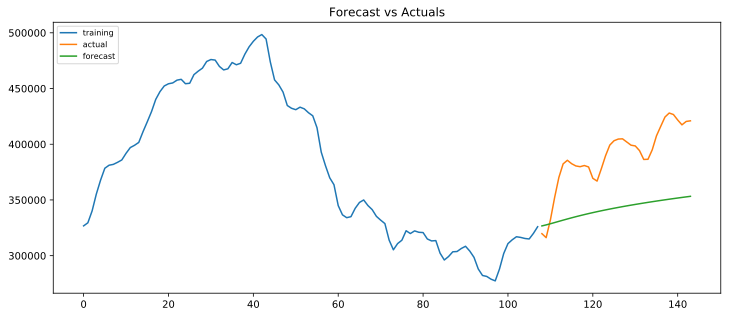

In [403]:
# Prediction plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(exog_train.MedianSoldPrice, label='training')
plt.plot(exog_test.MedianSoldPrice, label='actual')
plt.plot(pred.MedianSoldPrice, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [404]:
mse = ((pred['MedianSoldPrice'] - exog_test['MedianSoldPrice']) ** 2).mean()
rmse=np.sqrt(mse)
print(rmse)

51980.44693055102


In [405]:
# Fitting an AR(2) process
var_model2 = VAR(endog=exog_train)
var_model2_fit = var_model2.fit(2)
print(var_model2_fit.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 10, Dec, 2019
Time:                     22:42:08
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    12.9060
Nobs:                     106.000    HQIC:                   12.5922
Log likelihood:          -1086.28    FPE:                    237744.
AIC:                      12.3784    Det(Omega_mle):         196242.
--------------------------------------------------------------------
Results for equation MedianSoldPrice
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                    -8712.160935      9795.139153           -0.889           0.374
L1.MedianSoldPrice           1.633847         0.077860           20.984           0.000
L1.MedianMortageRate  

In [406]:
# Predicting the MedianSoldPrice of the test sample.
fc2 = var_model2_fit.forecast(var_model2_fit.y, steps=len(exog_test))
cols = exog_test.columns
pred2 = pd.DataFrame(index=exog_test.index,columns=[cols])

for j in range(0,3):
    for i in range(0, len(fc2)):
        pred2.iloc[i][j] = fc2[i][j]

/usr/local/lib/python3.7/site-packages/statsmodels/base/wrapper.py:35: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


In [407]:
pred2.columns = exog_test.columns

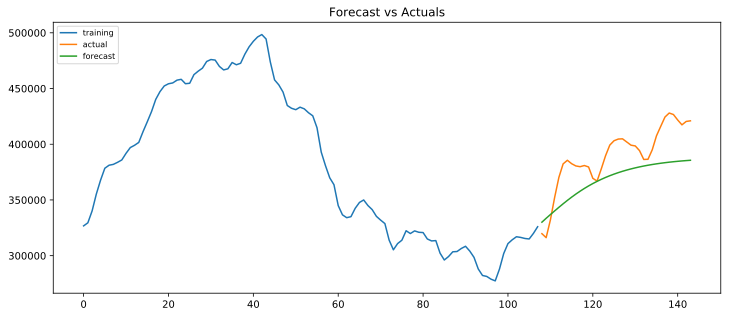

In [408]:
# Prediction plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(exog_train.MedianSoldPrice, label='training')
plt.plot(exog_test.MedianSoldPrice, label='actual')
plt.plot(pred2.MedianSoldPrice, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [409]:
# Calculating RMSE
mse = ((pred2['MedianSoldPrice'] - exog_test['MedianSoldPrice']) ** 2).mean()
rmse=np.sqrt(mse)
print(rmse)

26080.438494704806


In [410]:
# Fitting an AR(1) process
var_model3 = VAR(endog=exog_train)
var_model3_fit = var_model3.fit(3)
print(var_model3_fit.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 10, Dec, 2019
Time:                     22:42:21
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    13.2121
Nobs:                     105.000    HQIC:                   12.7611
Log likelihood:          -1070.79    FPE:                    256673.
AIC:                      12.4538    Det(Omega_mle):         195369.
--------------------------------------------------------------------
Results for equation MedianSoldPrice
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                   -12880.981485     10829.060821           -1.189           0.234
L1.MedianSoldPrice           1.724770         0.103581           16.651           0.000
L1.MedianMortageRate  

In [411]:
# Predicting the MedianSoldPrice of the test sample.
fc3 = var_model3_fit.forecast(var_model3_fit.y, steps=len(exog_test))
cols = exog_test.columns
pred3 = pd.DataFrame(index=exog_test.index,columns=[cols])

for j in range(0,3):
    for i in range(0, len(fc3)):
        pred3.iloc[i][j] = fc3[i][j]

/usr/local/lib/python3.7/site-packages/statsmodels/base/wrapper.py:35: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


In [412]:
pred3.columns = exog_test.columns

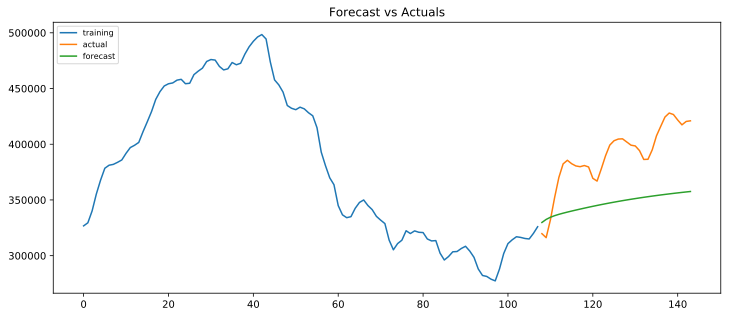

In [413]:
# Prediction plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(exog_train.MedianSoldPrice, label='training')
plt.plot(exog_test.MedianSoldPrice, label='actual')
plt.plot(pred3.MedianSoldPrice, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [414]:
# Calculting RMSE
mse = ((pred3['MedianSoldPrice'] - exog_test['MedianSoldPrice']) ** 2).mean()
rmse=np.sqrt(mse)
print(rmse)

47200.49813443495


# Extra: Univariate Structural Break Median Sold Price

### SARIMA Model

We used EViews framework to implement structual break SARIMA and TES models, and the results are included in the report.
Kindly refer to that for details.

In [415]:
zillow = pd.read_csv('zillow-carlifornia.csv')
zillow['Date'] = pd.to_datetime(zillow['Date'])
zillow.set_index('Date', inplace=True)
series = zillow['MedianSoldPrice_AllHomes.California']
series = series[0:144]

In [416]:
series_before = series[:60]
series_after = series[60:]

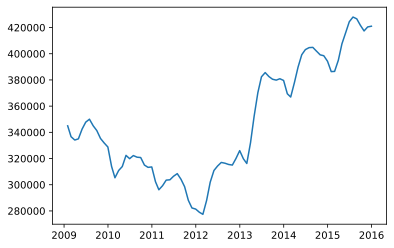

In [417]:
# Time series plot
pyplot.plot(series_after)
pyplot.show()

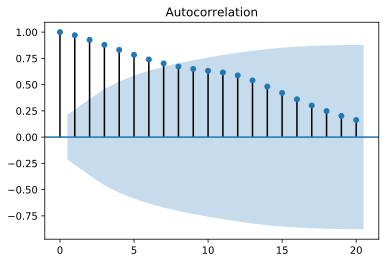

In [418]:
# ACF plot
plot_acf(series_after) 
plt.show()

In [419]:
# Train-test split
train_size = int(len(series_after) * 0.75)
train, test = series_after[1:train_size], series_after[train_size:]

In [420]:
# Fitting structural break SARIMA model
st_br_sarima_model = pm.auto_arima(train, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=False,
                           d=2, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(st_br_sarima_model.summary())

Fit ARIMA: order=(1, 2, 1); AIC=1217.738, BIC=1226.115, Fit time=0.102 seconds
Fit ARIMA: order=(0, 2, 0); AIC=1225.557, BIC=1229.745, Fit time=0.003 seconds
Fit ARIMA: order=(1, 2, 0); AIC=1227.389, BIC=1233.672, Fit time=0.065 seconds
Fit ARIMA: order=(0, 2, 1); AIC=1227.132, BIC=1233.415, Fit time=0.021 seconds
Fit ARIMA: order=(2, 2, 1); AIC=1212.894, BIC=1223.366, Fit time=0.172 seconds
Fit ARIMA: order=(2, 2, 0); AIC=1222.803, BIC=1231.181, Fit time=0.059 seconds
Fit ARIMA: order=(2, 2, 2); AIC=1214.794, BIC=1227.360, Fit time=0.275 seconds
Fit ARIMA: order=(3, 2, 2); AIC=1223.463, BIC=1238.124, Fit time=0.154 seconds
Fit ARIMA: order=(3, 2, 1); AIC=nan, BIC=nan, Fit time=0.064 seconds
Total fit time: 0.917 seconds
                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                   60
Model:                 ARIMA(2, 2, 1)   Log Likelihood                -601.447
Method:                       cs

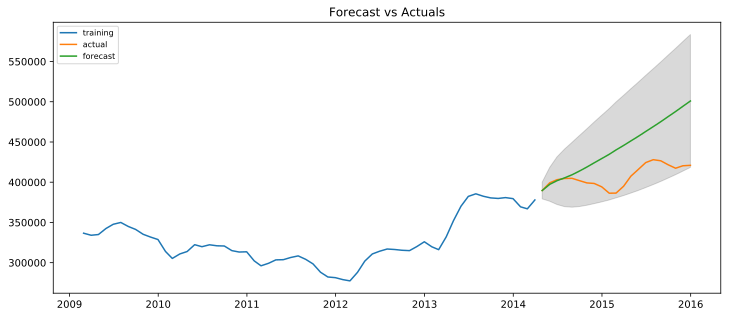

In [421]:
# Prediction plot
fitted = st_br_sarima_model.fit(train)
fc, conf = fitted.predict(len(test),return_conf_int=True,alpha=0.05)
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [422]:
# Calculating RMSE
mse = ((fc_series - test) ** 2).mean()
rmse=round(np.sqrt(mse), 2)
print(rmse)

43522.61


### TES (Exponential Smoothing) Model

In [290]:
# Fitting TES models
st_br_tes_model1 = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12,damped=True)
st_br_tes_model2 = ExponentialSmoothing(train, trend="add", seasonal="mul", seasonal_periods=12, damped=True)
st_br_tes_model3 = ExponentialSmoothing(train, trend="mul", seasonal="mul", seasonal_periods=12, damped=True)
st_br_tes_model4 = ExponentialSmoothing(train, trend="mul", seasonal="add", seasonal_periods=12, damped=True)

fit = st_br_tes_model1.fit()
pred = fit.forecast(len(test))
fit2 = st_br_tes_model2.fit()
pred2 = fit2.forecast(len(test))
fit3 = st_br_tes_model3.fit()
pred3 = fit3.forecast(len(test))
fit4 = st_br_tes_model4.fit()
pred4 = fit4.forecast(len(test))

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/holt

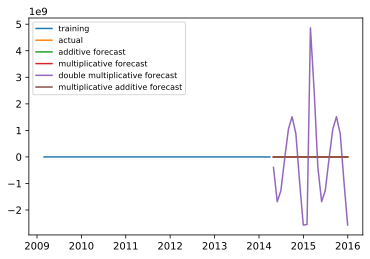

In [291]:
# Prediction plot
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred, label='additive forecast')
plt.plot(pred2, label='multiplicative forecast')
plt.plot(pred3, label='double multiplicative forecast')
plt.plot(pred4, label='multiplicative additive forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [292]:
# Compute RMSE
rmse1 = np.sqrt(np.mean(np.square(test.values - pred.values)))
rmse2 = np.sqrt(np.mean(np.square(test.values - pred2.values)))
rmse3 = np.sqrt(np.mean(np.square(test.values - pred3.values)))
rmse4 = np.sqrt(np.mean(np.square(test.values - pred4.values)))


print(rmse1)
print(rmse2)
print(rmse3)
print(rmse4)

14583.895511311182
21366.227425552974
1805228890.0531077
7229.810969189716


# Residual Diagnostics

In [293]:
# Residuals
resid = test.values - pred4.values

In [294]:
resid

array([ -4081.41274138,  -3105.24146134,  -2403.97306254,  -1724.57704731,
         -211.72597647,  -3059.50775977,  -4493.14868499,  -4977.55979128,
        -8433.64531848,  -6601.39585066,  -3783.52917619,  -9879.06724691,
       -11756.86559835, -11973.04941021,  -6964.93001568,  -4329.48134468,
        -4511.3804104 ,  -9554.71959973, -12634.72970259,  -9541.32628537,
        -8395.4181404 ])

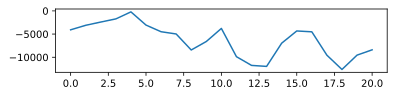

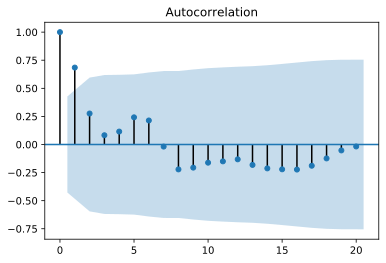

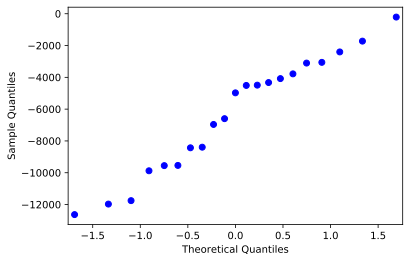

In [295]:
# Plotting residuals
plt.subplot(3,1,1)
plt.plot(resid) #stationary
plt.show()
plot_acf(resid,lags=20) #uncorrelated
plt.show()
sm.qqplot(resid) #normal distribution
plt.show()

In [296]:
acorr_ljungbox(resid, lags=10)

(array([11.31701518, 13.25090825, 13.43256621, 13.80826744, 15.57387245,
        17.0452786 , 17.05731248, 18.88456919, 20.59269445, 21.74559275]),
 array([0.000768  , 0.00132618, 0.00378869, 0.00793281, 0.00817209,
        0.00911827, 0.01703034, 0.01548931, 0.01458699, 0.01645442]))

# Selected Model

We choose structural break TES model 4 (multiplicative trend & additive seasonality) as our final model because the RMSE for this model is 7229.81, which is lowest among all other models that we fit.

# Forecast

In [174]:
forecast_data = zillow[144:]
forecast_data.head()

,MedianSoldPrice_AllHomes.California,MedianMortageRate,UnemploymentRate,MedianRentalPrice_AllHomes.California
Date,,,,
2016-01-31,NaN,3.96,4.9,2300.0
2016-02-29,NaN,3.60,5.0,2350.0
2016-03-31,NaN,3.60,5.0,2400.0
2016-04-30,NaN,3.59,4.8,2395.0
2016-05-31,NaN,3.59,4.8,2395.0


In [176]:
# Forecasting
selected_model = ExponentialSmoothing(series_after, trend="mul", seasonal="add", seasonal_periods=12, damped=True)
selected_model_fit = selected_model.fit()
predictions = selected_model_fit.forecast(len(forecast_data))
predictions

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


2016-01-31    414152.868292
2016-02-29    415650.075011
2016-03-31    428430.047099
2016-04-30    444273.678431
2016-05-31    455196.411344
2016-06-30    461704.494063
2016-07-31    462357.991084
2016-08-31    459173.266045
2016-09-30    454682.257054
2016-10-31    451997.973298
2016-11-30    454411.799013
2016-12-31    452637.173976
2017-01-31    447134.106784
2017-02-28    448838.639358
2017-03-31    461827.240587
2017-04-30    477880.812541
2017-05-31    489014.805799
2017-06-30    495735.476882
2017-07-31    496602.898634
2017-08-31    493633.443096
Freq: M, dtype: float64

# Forecast plot

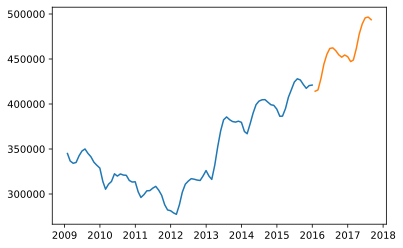

In [177]:
plt.plot(series_after, label='training')
plt.plot(predictions, label='actual')
plt.show()

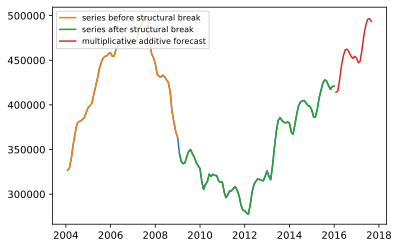

In [423]:
plt.plot(series)
plt.plot(series_before, label='series before structural break')
plt.plot(series_after, label='series after structural break')
plt.plot(predictions, label='multiplicative additive forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [424]:
dataset = pd.DataFrame({'Date': predictions.index, 'prediction': predictions.values}, columns=['Date', 'prediction'])
dataset = dataset.reset_index()
dataset = dataset.drop(columns=['index'])
dataset.to_csv('prediction.csv', encoding='utf-8', index=False)
dataset

,Date,prediction
0,2016-01-31,414152.868292
1,2016-02-29,415650.075011
2,2016-03-31,428430.047099
3,2016-04-30,444273.678431
4,2016-05-31,455196.411344
5,2016-06-30,461704.494063
6,2016-07-31,462357.991084
7,2016-08-31,459173.266045
8,2016-09-30,454682.257054
9,2016-10-31,451997.973298
